<a href="https://colab.research.google.com/github/Raghavnadiminti/Deepfake_ai/blob/main/deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q kaggle kaggle-cli
!pip install -q torch torchvision torchaudio transformers kagglehub scikit-image opencv-python matplotlib seaborn


import os
os.environ['KAGGLE_USERNAME'] = "KAGGLE_API_KEY"
os.environ['KAGGLE_KEY'] = ""
os.environ['KAGGLE_API_TOKEN'] = ""


import kagglehub, shutil, time
print("Downloading dataset via kagglehub...")
t0 = time.time()
path = kagglehub.dataset_download("wish096/ff-andcelebdf-frame-dataset-by-wish")
print("Downloaded to:", path, " (took {:.1f}s)".format(time.time()-t0))

TARGET = "/content/dataset"
shutil.rmtree(TARGET, ignore_errors=True)
shutil.copytree(path, TARGET, dirs_exist_ok=True)
print("Copied dataset into", TARGET)


import os
print("Top-level files/dirs in dataset:")
print(os.listdir(TARGET)[:80])


if os.path.isdir(os.path.join(TARGET, "frame_dataset_v3", "frame_dataset_v3")):
    DATA_ROOT = os.path.join(TARGET, "frame_dataset_v3", "frame_dataset_v3")
elif os.path.isdir(os.path.join(TARGET, "frame_dataset_v3")):
    DATA_ROOT = os.path.join(TARGET, "frame_dataset_v3")
else:

    DATA_ROOT = TARGET
print("Using DATA_ROOT =", DATA_ROOT)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for lxml
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (lxml)
Using Colab cache for faster access

In [ ]:

import os, shutil, hashlib, numpy as np, cv2, time
from collections import defaultdict, Counter
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import torch, torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix



In [ ]:


try:
    DATA_ROOT
except NameError:
    DATA_ROOT = "/content/dataset"

SAFE_ROOT = "/content/safe_dataset"
SUBSET_FRAC = 0.10
MIN_ITEMS = 800
EPOCHS1 = 1
EPOCHS2 = 1
BATCH_SIZE = 64 if torch.cuda.is_available() else 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("DATA_ROOT =", DATA_ROOT)
print("SAFE_ROOT =", SAFE_ROOT)
print("Device =", DEVICE)


In [ ]:

def collect_files(root):
    paths, labels = [], []
    for label_name, label in (("REAL",1), ("FAKE",0)):
        p = os.path.join(root, label_name)
        if not os.path.isdir(p):
            p = os.path.join(root, label_name.lower())
        if not os.path.isdir(p):
            continue
        for fname in os.listdir(p):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                paths.append(os.path.join(p, fname))
                labels.append(label)
    return paths, labels

In [ ]:



paths, labels = collect_files(DATA_ROOT)
print("Total images found:", len(paths))
print("Class distribution:", Counter(labels))
if len(paths) == 0:
    raise SystemExit("No images found under DATA_ROOT. Fix DATA_ROOT and ensure REAL/FAKE folders exist.")


print("Computing hashes (may take a little)...")
hash_to_paths = defaultdict(list)
path_hash = {}
for p in paths:
    try:
        with open(p, "rb") as f:
            h = hashlib.md5(f.read()).hexdigest()
    except Exception as e:
        h = None
    path_hash[p] = h
    hash_to_paths[h].append(p)


dup_groups = [v for k,v in hash_to_paths.items() if k is not None and len(v) > 1]
print("Exact duplicate groups (identical file content):", len(dup_groups))
if len(dup_groups)>0:
    print("Example duplicate group (first 5 paths):", dup_groups[0][:5])


basename_map = defaultdict(set)
for p,l in zip(paths, labels):
    bn = os.path.basename(p).lower()
    basename_map[bn].add(l)
leaked_names = [bn for bn, labs in basename_map.items() if len(labs) > 1]
print("Filenames appearing with multiple labels (possible leakage):", len(leaked_names))
if len(leaked_names)>0:
    print("Example leaked filenames:", leaked_names[:5])



In [ ]:

unique_reps = []
hash_label_map = {}
inconsistent_hashes = []
for h, p_list in hash_to_paths.items():
    if h is None:
        continue
    labs = set()
    for p in p_list:

        labs.add(1 if ("real" in p.lower() and "/real" in p.lower() or os.path.basename(os.path.dirname(p)).lower()=='real') else
                 0 if ("fake" in p.lower() or os.path.basename(os.path.dirname(p)).lower()=='fake') else None)
    if None in labs or len(labs) > 1:
        inconsistent_hashes.append(h)
        continue
    lab = labs.pop()
    hash_label_map[h] = lab

    unique_reps.append((h, p_list[0], lab))

print("Unique hash reps:", len(unique_reps))
print("Inconsistent hashes (different labels under same hash):", len(inconsistent_hashes))


h_list = [h for h,_,_ in unique_reps]
rep_paths = [p for _,p,_ in unique_reps]
rep_labels = [lab for _,_,lab in unique_reps]
h_list = np.array(h_list); rep_paths = np.array(rep_paths); rep_labels = np.array(rep_labels)


if len(rep_paths) < 50:
    print("WARNING: very few unique files found; falling back to original paths.")
    rep_paths = np.array(paths)
    rep_labels = np.array(labels)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(rep_paths, rep_labels))
train_hashes = set(h_list[train_idx])
val_hashes = set(h_list[val_idx])
print("Unique train reps:", len(train_idx), " unique val reps:", len(val_idx))


In [ ]:


train_files, val_files = [], []
train_labels_full, val_labels_full = [], []
for p in paths:
    h = path_hash[p]
    if h in train_hashes:
        train_files.append(p); train_labels_full.append(1 if ("real" in p.lower() and "/real" in p.lower() or os.path.basename(os.path.dirname(p)).lower()=='real') else 0)
    elif h in val_hashes:
        val_files.append(p); val_labels_full.append(1 if ("real" in p.lower() and "/real" in p.lower() or os.path.basename(os.path.dirname(p)).lower()=='real') else 0)
    else:

        pass

print("Files assigned to train:", len(train_files), " val:", len(val_files))


if os.path.exists(SAFE_ROOT):
    shutil.rmtree(SAFE_ROOT)
os.makedirs(os.path.join(SAFE_ROOT, "REAL"), exist_ok=True)
os.makedirs(os.path.join(SAFE_ROOT, "FAKE"), exist_ok=True)

def safe_copy(list_files, list_labels):
    for p,l in zip(list_files, list_labels):
        dest_dir = os.path.join(SAFE_ROOT, "REAL" if l==1 else "FAKE")

        h = path_hash[p] if path_hash[p] is not None else hashlib.md5(p.encode()).hexdigest()
        dest_name = f"{h}_{os.path.basename(p)}"
        dest_path = os.path.join(dest_dir, dest_name)
        try:
            shutil.copy2(p, dest_path)
        except Exception as e:
            # ignore copy errors
            pass

print("Copying train files to safe dataset (this may take a short while)...")
safe_copy(train_files, train_labels_full)
print("Copying val files to safe dataset...")
safe_copy(val_files, val_labels_full)


def folder_count(root):
    cnt_real = len([f for f in os.listdir(os.path.join(root,"REAL")) if f.lower().endswith(('.jpg','.jpeg','.png'))]) if os.path.isdir(os.path.join(root,"REAL")) else 0
    cnt_fake = len([f for f in os.listdir(os.path.join(root,"FAKE")) if f.lower().endswith(('.jpg','.jpeg','.png'))]) if os.path.isdir(os.path.join(root,"FAKE")) else 0
    return cnt_real, cnt_fake

real_cnt, fake_cnt = folder_count(SAFE_ROOT)
print("SAFE dataset counts -> REAL:", real_cnt, "FAKE:", fake_cnt)


def show_safe_samples(root, n=3):
    fig = plt.figure(figsize=(10,5))
    i=1
    for lab, name in [(1,"REAL"), (0,"FAKE")]:
        dirp = os.path.join(root, name)
        files = [os.path.join(dirp,f) for f in os.listdir(dirp) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        for p in files[:n]:
            img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
            ax = fig.add_subplot(2,n,i); ax.imshow(cv2.resize(img,(224,224))); ax.axis('off'); ax.set_title(name)
            i+=1
    plt.show()

show_safe_samples(SAFE_ROOT, n=3)


In [ ]:


class SafeDataset(Dataset):
    def __init__(self, root, mode="train"):
        self.paths, self.labels = [], []
        p_real = os.path.join(root, "REAL"); p_fake = os.path.join(root, "FAKE")

        for lab, pdir in [(1, p_real), (0, p_fake)]:
            if not os.path.isdir(pdir): continue
            for f in os.listdir(pdir):
                if f.lower().endswith(('.jpg','.jpeg','.png')):
                    self.paths.append(os.path.join(pdir,f))
                    self.labels.append(lab)

        combined = list(zip(self.paths, self.labels))
        random_state = 42
        np.random.RandomState(random_state).shuffle(combined)
        self.paths, self.labels = zip(*combined) if len(combined)>0 else ([],[])
        # transforms: augment + normalize
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.8,1.0)),
            T.RandomHorizontalFlip(0.5),
            T.ColorJitter(0.1,0.1,0.1,0.05),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        lab = self.labels[idx]
        img = cv2.imread(p)
        if img is None:
            img = np.zeros((224,224,3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)

        gray = cv2.cvtColor(cv2.resize(cv2.imread(p), (224,224)), cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3,3), 0)
        residual = gray.astype(np.float32) - blurred.astype(np.float32)
        r_mean, r_std = residual.mean(), residual.std()
        lap = cv2.Laplacian(gray, cv2.CV_64F)
        hf = np.mean(np.abs(lap))
        fvec = torch.tensor([r_mean, r_std, 0.0, hf], dtype=torch.float32)
        return img, fvec, torch.tensor(lab, dtype=torch.float32)

safe_ds = SafeDataset(SAFE_ROOT)
if len(safe_ds) < 20:
    raise SystemExit("Safe dataset too small. Diagnostic indicates insufficient safe images. Investigate duplicates/leakage.")


In [ ]:

train_n = int(0.8 * len(safe_ds))
val_n = len(safe_ds) - train_n
train_ds, val_ds = random_split(safe_ds, [train_n, val_n])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print("Safe dataset sizes -> total:", len(safe_ds), " train:", len(train_ds), " val:", len(val_ds))

In [ ]:



class Stage1Quick(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.mobilenet_v3_small(pretrained=True)
        self.backbone.classifier = nn.Identity()
        self.forensic = nn.Sequential(nn.Linear(4,32), nn.ReLU(), nn.Linear(32,16))
        self.head = nn.Sequential(nn.Linear(576+16,128), nn.ReLU(), nn.Linear(128,1), nn.Sigmoid())
    def forward(self, x, f):
        v = self.backbone(x)
        f = self.forensic(f)
        return self.head(torch.cat([v,f], dim=1))

stage1_q = Stage1Quick().to(DEVICE)
crit = nn.BCELoss()
opt = torch.optim.Adam(stage1_q.parameters(), lr=1e-4)

print("\nQuick training Stage-1 on safe dataset (1 epoch)...")
stage1_q.train()
tstart = time.time()
for imgs, fvecs, labs in train_loader:
    imgs = imgs.to(DEVICE); fvecs = fvecs.to(DEVICE); labs = labs.to(DEVICE).unsqueeze(1)
    preds = stage1_q(imgs, fvecs)
    loss = crit(preds, labs)
    opt.zero_grad(); loss.backward(); opt.step()
print("Stage-1 quick train finished in {:.1f}s".format(time.time()-tstart))


stage1_q.eval()
all_p, all_t = [], []
with torch.no_grad():
    for imgs, fvecs, labs in val_loader:
        imgs = imgs.to(DEVICE); fvecs = fvecs.to(DEVICE)
        out = stage1_q(imgs, fvecs).cpu().numpy().flatten()
        all_p.extend((out>0.5).astype(int).tolist())
        all_t.extend(labs.numpy().astype(int).tolist())
acc_stage1_safe = accuracy_score(all_t, all_p)
print("Stage-1 accuracy on SAFE val:", acc_stage1_safe)


from transformers import CLIPModel, AutoProcessor
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# freeze except layer norms
for name, p in clip.named_parameters():
    if "layer_norm" not in name.lower():
        p.requires_grad = False


DATA_ROOT = /content/dataset/frame_dataset_v3/frame_dataset_v3
SAFE_ROOT = /content/safe_dataset
Device = cuda
Total images found: 38940
Class distribution: Counter({1: 22669, 0: 16271})
Computing hashes (may take a little)...
Exact duplicate groups (identical file content): 14
Example duplicate group (first 5 paths): ['/content/dataset/frame_dataset_v3/frame_dataset_v3/real/celeb_real_id39_0004_f0.jpg', '/content/dataset/frame_dataset_v3/frame_dataset_v3/fake/celeb_fake_id39_id42_0004_f0.jpg', '/content/dataset/frame_dataset_v3/frame_dataset_v3/fake/celeb_fake_id39_id45_0004_f0.jpg', '/content/dataset/frame_dataset_v3/frame_dataset_v3/fake/celeb_fake_id39_id48_0004_f0.jpg', '/content/dataset/frame_dataset_v3/frame_dataset_v3/fake/celeb_fake_id39_id47_0004_f0.jpg']
Filenames appearing with multiple labels (possible leakage): 0
Unique hash reps: 38875
Inconsistent hashes (different labels under same hash): 2
Unique train reps: 31100  unique val reps: 7775
Files assigned to train: 31141 

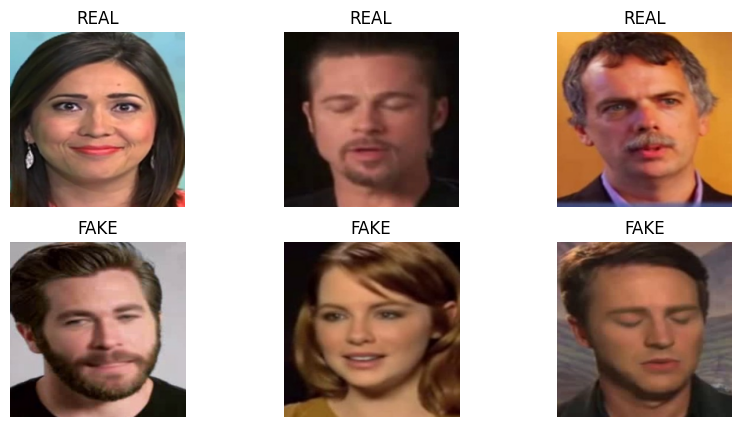

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `wei

Safe dataset sizes -> total: 38921  train: 31136  val: 7785
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 88.4MB/s]



Quick training Stage-1 on safe dataset (1 epoch)...
Stage-1 quick train finished in 332.6s
Stage-1 accuracy on SAFE val: 0.8745022479126525


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]


Quick training Stage-2 on safe dataset (1 epoch)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Stage-2 quick train finished in 398.7s
Stage-2 accuracy on SAFE val: 0.6971098265895954


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Combined val accuracy on SAFE dataset: 0.8599871547848427


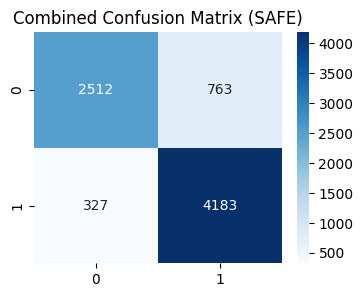


=== DIAGNOSTIC SUMMARY ===
Total original images: 38940
Duplicate groups (exact content): 14
Filenames used with multiple labels: 0
Inconsistent hashes (same hash with different labels): 2
Assigned files -> train: 31141  val: 7780
SAFE dataset counts -> REAL/FAKE: (22667, 16254)
Accuracies on SAFE val -> Stage1: 0.8745022479126525  Stage2: 0.6971098265895954  Combined: 0.8599871547848427
Saved quick safe checkpoints.


In [ ]:

class Stage2Quick(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.forensic = nn.Sequential(nn.Linear(4,128), nn.ReLU(), nn.Linear(128,128))
        self.fusion = nn.Sequential(nn.Linear(512+128,256), nn.ReLU(), nn.Linear(256,1), nn.Sigmoid())
    def forward(self, imgs, fvec):
        # imgs = batch x C x H x W in 0..1
        imgs_np = (imgs.permute(0,2,3,1).cpu().numpy() * 255).astype('uint8')
        clip_inputs = processor(images=list(imgs_np), return_tensors="pt")
        pixel_values = clip_inputs["pixel_values"].to(DEVICE)
        emb = self.clip.get_image_features(pixel_values=pixel_values)
        femb = self.forensic(fvec)
        return self.fusion(torch.cat([emb, femb], dim=1))

stage2_q = Stage2Quick(clip).to(DEVICE)
opt2 = torch.optim.Adam(filter(lambda p: p.requires_grad, stage2_q.parameters()), lr=1e-4)

print("\nQuick training Stage-2 on safe dataset (1 epoch)...")
stage2_q.train()
tstart = time.time()
for imgs, fvecs, labs in train_loader:
    imgs = imgs.to(DEVICE); fvecs = fvecs.to(DEVICE); labs = labs.to(DEVICE).unsqueeze(1)
    preds = stage2_q(imgs, fvecs)
    loss = crit(preds, labs)
    opt2.zero_grad(); loss.backward(); opt2.step()
print("Stage-2 quick train finished in {:.1f}s".format(time.time()-tstart))


stage2_q.eval()
all_p2, all_t2 = [], []
with torch.no_grad():
    for imgs, fvecs, labs in val_loader:
        imgs = imgs.to(DEVICE); fvecs = fvecs.to(DEVICE)
        out = stage2_q(imgs, fvecs).cpu().numpy().flatten()
        all_p2.extend((out>0.5).astype(int).tolist())
        all_t2.extend(labs.numpy().astype(int).tolist())
acc_stage2_safe = accuracy_score(all_t2, all_p2)
print("Stage-2 accuracy on SAFE val:", acc_stage2_safe)


combined_preds, combined_trues = [], []
with torch.no_grad():
    for imgs, fvecs, labs in val_loader:
        imgs = imgs.to(DEVICE); fvecs = fvecs.to(DEVICE)
        s1 = stage1_q(imgs, fvecs).cpu().numpy().flatten()
        s2 = stage2_q(imgs, fvecs).cpu().numpy().flatten()
        final = ((s1 + s2)/2.0 > 0.5).astype(int).tolist()
        combined_preds.extend(final); combined_trues.extend(labs.numpy().astype(int).tolist())
acc_combined_safe = accuracy_score(combined_trues, combined_preds)
print("Combined val accuracy on SAFE dataset:", acc_combined_safe)

cm = confusion_matrix(combined_trues, combined_preds)
plt.figure(figsize=(4,3)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title("Combined Confusion Matrix (SAFE)"); plt.show()


print("\n=== DIAGNOSTIC SUMMARY ===")
print("Total original images:", len(paths))
print("Duplicate groups (exact content):", len(dup_groups))
print("Filenames used with multiple labels:", len(leaked_names))
print("Inconsistent hashes (same hash with different labels):", len(inconsistent_hashes))
print("Assigned files -> train:", len(train_files), " val:", len(val_files))
print("SAFE dataset counts -> REAL/FAKE:", folder_count(SAFE_ROOT))
print("Accuracies on SAFE val -> Stage1:", acc_stage1_safe, " Stage2:", acc_stage2_safe, " Combined:", acc_combined_safe)


# Save safe models for later
torch.save(stage1_q.state_dict(), "/content/stage1_safe_quick.pth")
torch.save(stage2_q.state_dict(), "/content/stage2_safe_quick.pth")
print("Saved quick safe checkpoints.")